<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>

**Goals of this notebook:**

Identify the following conditions of the sensor:
- dry
- connected lake
- disconnected lake
- overwash events

For now we would like to see:
- A time series of the pressure compared to tide times
- Detrended graphs of high tide conditions to see overwash events
- Zoom in Graphs of our main overwash events 

Questions:
- Why is the graph flucuating like it is? Is it due to tide times?
- How do we identify different conditions?
- How to download water level height, I have tried but is it the correct file??

In [7]:
## import necessary packages

import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy.optimize import root
import matplotlib.patches as pat
import matplotlib.dates as mdates
import pytz
#import netCDF4 as nc4
import scipy.signal
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy.fftpack import fft    #importing Fourier transform package
from scipy.stats import chi2     #importing confidence interval package

from scipy.optimize import root


In [8]:
# Input cell
# Here you can import all the files which are needed for the plots below

folder = r"C:\Users\mscha\Documents\Stormtroopers\Data_files\Data_storm_benjamin\Lake_Analysis"

Start_time = datetime.datetime(2025,10,24,0,0,0) # (YYYY,MM,DD,hh,mm,ss)
End_time = datetime.datetime(2025,10,30,12,0,0) # (YYYY,MM,DD,hh,mm,ss)

air_pressure_file_name = 'HVH_AirPressure_23102025_30102025.txt'
tide_NAP_file_name = 'Tide_Data_Benjamin.csv'
waterlevel_NAP_file_name = 'Water_Level_Benjamin.csv'
wave_file_name = 'Wave_Data_Benjamin.csv'
raw_pressure_sensor_data_file_name = '202438_20251031_1250_stormtroopers Oct 2025_data.txt'
smooth_pressure_sensor_data_file_name = '1minute_pressure_data.csv'




In [9]:
## Build full paths 

air_pressure_path = os.path.join(folder, air_pressure_file_name)
tide_NAP_path = os.path.join(folder, tide_NAP_file_name)
waterlevel_NAP_path = os.path.join(folder, waterlevel_NAP_file_name)
raw_pressure_path = os.path.join(folder, raw_pressure_sensor_data_file_name)
smooth_pressure_path = os.path.join(folder, smooth_pressure_sensor_data_file_name)

In [10]:
## Functions

def rbr_data_reader(file):
    
    '''
    Conversion of RBR file to workable dataframe. Note that the time is assumed to be CET,
    and therefore the conversion to time_unix subtracts 3600 s because the pd.to_numeric assumes GMT.
    
    BE CAREFUL! THIS FUNCTION ASSUMES WINTER TIME (UTC + 2HR)
    '''
    
    rbr_raw = pd.read_csv(file, parse_dates=['Time'])#, date_parser=dateparse_rbr)

    rbr = pd.DataFrame({
        'time':rbr_raw.Time,
        'time_unix': pd.to_numeric(rbr_raw.Time)/10**9-7200,  # If summertime subtract 7200 s
        'dt_s': np.arange(0,len(rbr_raw.Time)*0.125, 0.125),
        'pressure':rbr_raw.Pressure * 0.1 * 100000}) #dbar
    
    return rbr

def convert_pressure_to_surface_elevation(Pressure, z_sensor, sensor_height):

    '''
    Convert pressure data to surface elevation using the root finding method.
    
    Inputs:
    Pressure: array of pressure data in Pa
    z_sensor: depth of the sensor below mean sea level in m (positive value)
    sensor_height: height of the sensor above the lake bed in m (positive value)
    
    Outputs:
    eta: array of surface elevation in m
    '''
    
    g = 9.81  # m/s^2
    rho = 1000  # kg/m^3, density of freshwater

    eta = np.zeros_like(Pressure)

    for i in range(len(Pressure)):
        P = Pressure[i]

        # Define the function to find the root
        def func(eta_i):
            h = z_sensor + sensor_height + eta_i  # total water depth
            return P - rho * g * h

        # Initial guess for eta
        eta_guess = 0.0

        # Use root finding to solve for eta
        sol = root(func, eta_guess)
        eta[i] = sol.x[0]

    return eta

    


In [11]:
# Read and convert data

# Rbr pressure sensor data

rbr_data = rbr_data_reader(raw_pressure_path)
rbr_pressure_raw = rbr_data.set_index('time')
rbr_pressure_raw = rbr_data['pressure'].values


# Air pressure at Hoek van Holland

types_dict_ap = {'YYYYMMDD': str,'HH': float,'P': float}
air_pressure_raw = pd.read_csv(
    air_pressure_path,
    skiprows=32,
    delimiter=',',
    skipinitialspace=True,
    usecols=[1,2,3],
    dtype=types_dict_ap,
    names=['YYYYMMDD','HH','P']
    )

air_pressure_raw['time'] = pd.to_datetime(air_pressure_raw['YYYYMMDD'], format='%Y%m%d') + pd.to_timedelta(air_pressure_raw['HH'], unit='h')

air_pressure = air_pressure_raw.set_index('time')
air_pressure = air_pressure[['P']]*10 # Convert 0.1 hPa to Pa

# Tide at Hoek van Holland (NAP)
types_dict_tide = {'Date': str,'Time': str,'Tide_NAP_cm': float}
tide_NAP_raw = pd.read_csv(
    tide_NAP_path,
    delimiter=';',
        skipinitialspace=True,
        skiprows=1,
        usecols=[0,1,3],
        dtype=types_dict_tide,
        names=['Date','Time','Tide_NAP_cm']
    )

tide_NAP_raw['time'] = pd.to_datetime(tide_NAP_raw['Date'] + ' ' + tide_NAP_raw['Time'], format='%d-%m-%Y %H:%M')
tide_NAP = tide_NAP_raw.set_index('time')
tide_NAP = tide_NAP[['Tide_NAP_cm']]/100 # Convert cm to m

# Water level (NAP)

types_dict_wl = {'Date': str,'Time': str,'Waterlevel_NAP_cm': float}
waterlevel_NAP_raw = pd.read_csv(
    waterlevel_NAP_path,
        delimiter=';',
        skiprows=1,
        skipinitialspace=True,
        usecols=[21,22,24],
        dtype=types_dict_wl,
        names=['Date','Time','Waterlevel_NAP_cm']
    )

waterlevel_NAP_raw['time'] = pd.to_datetime(waterlevel_NAP_raw['Date'] + ' ' + waterlevel_NAP_raw['Time'], format='%d-%m-%Y %H:%M:%S')
waterlevel_NAP = waterlevel_NAP_raw.set_index('time')
waterlevel_NAP = waterlevel_NAP[['Waterlevel_NAP_cm']]/100 # Convert cm to m

# Wave data

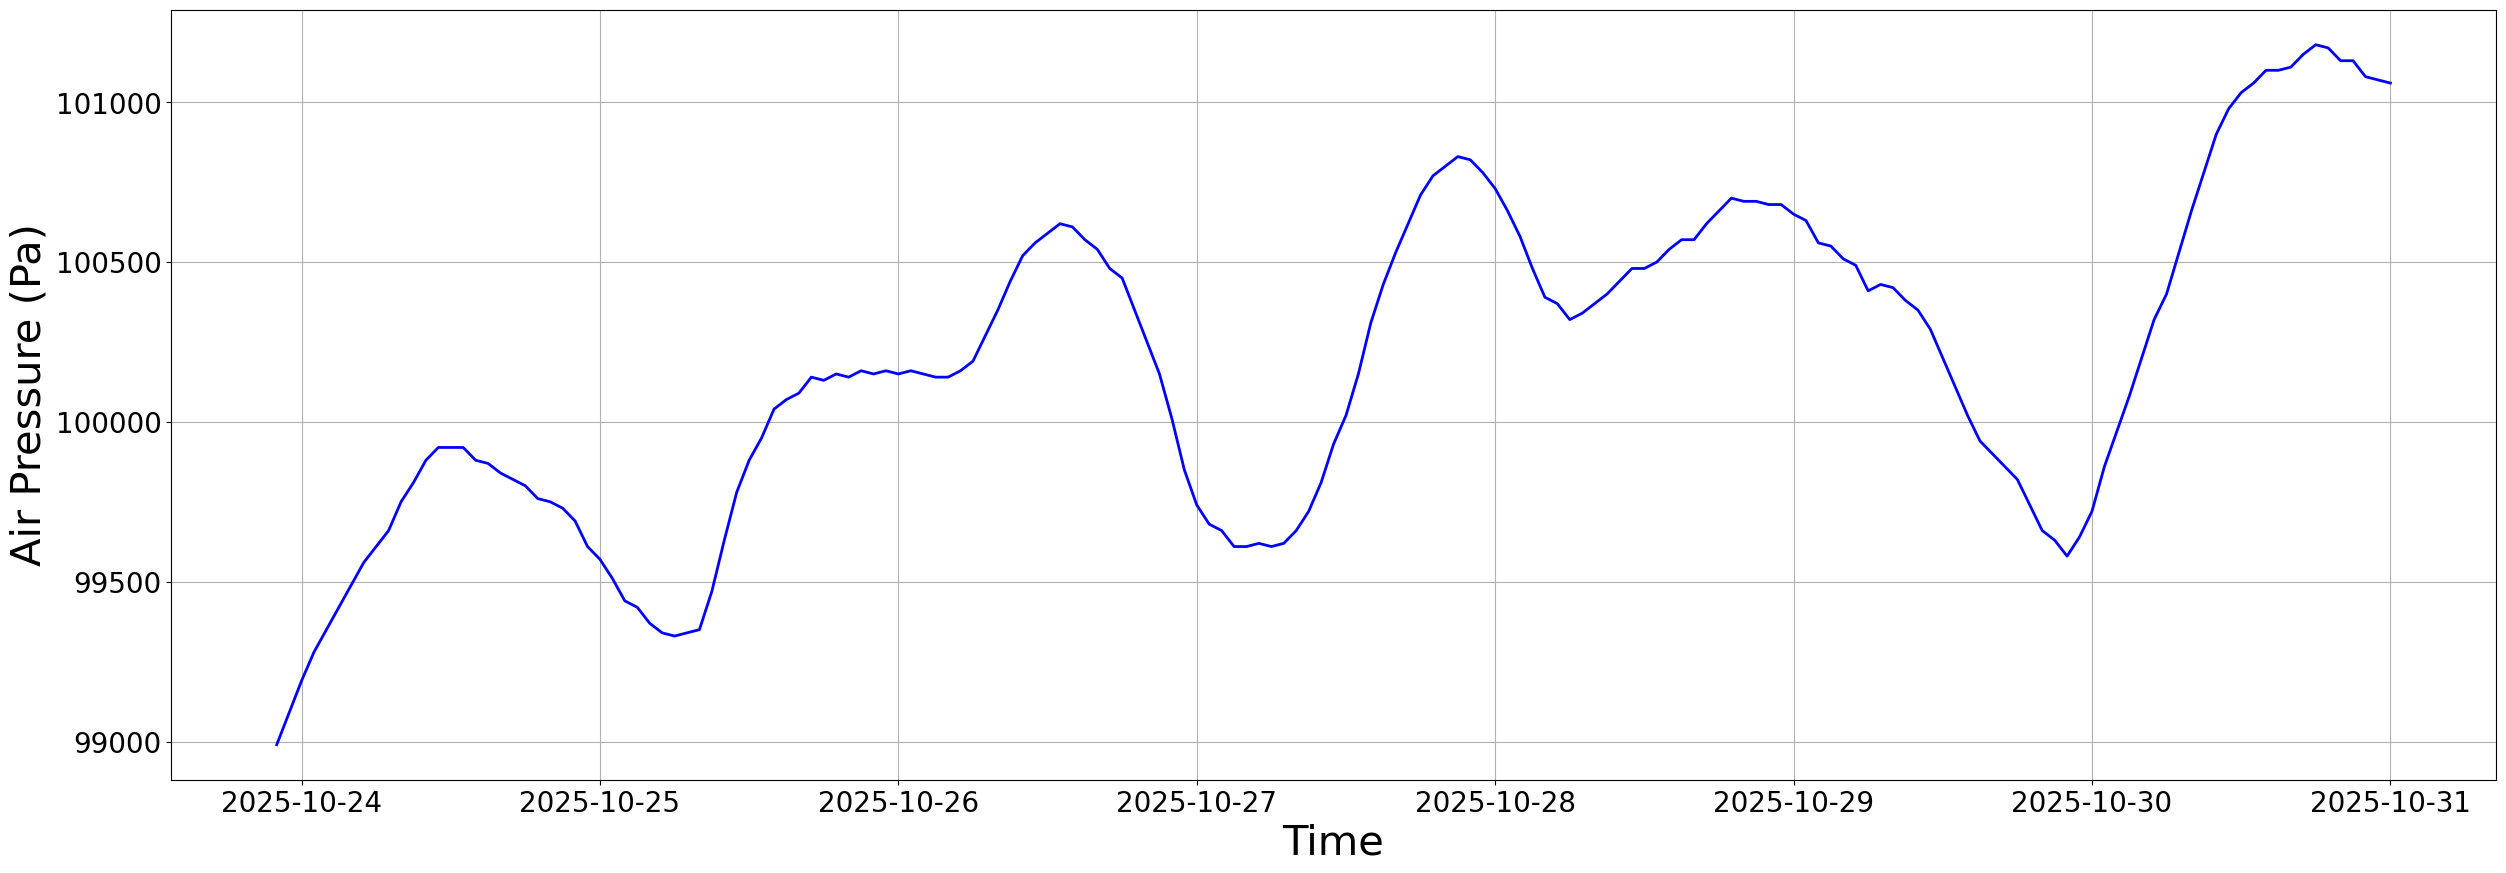

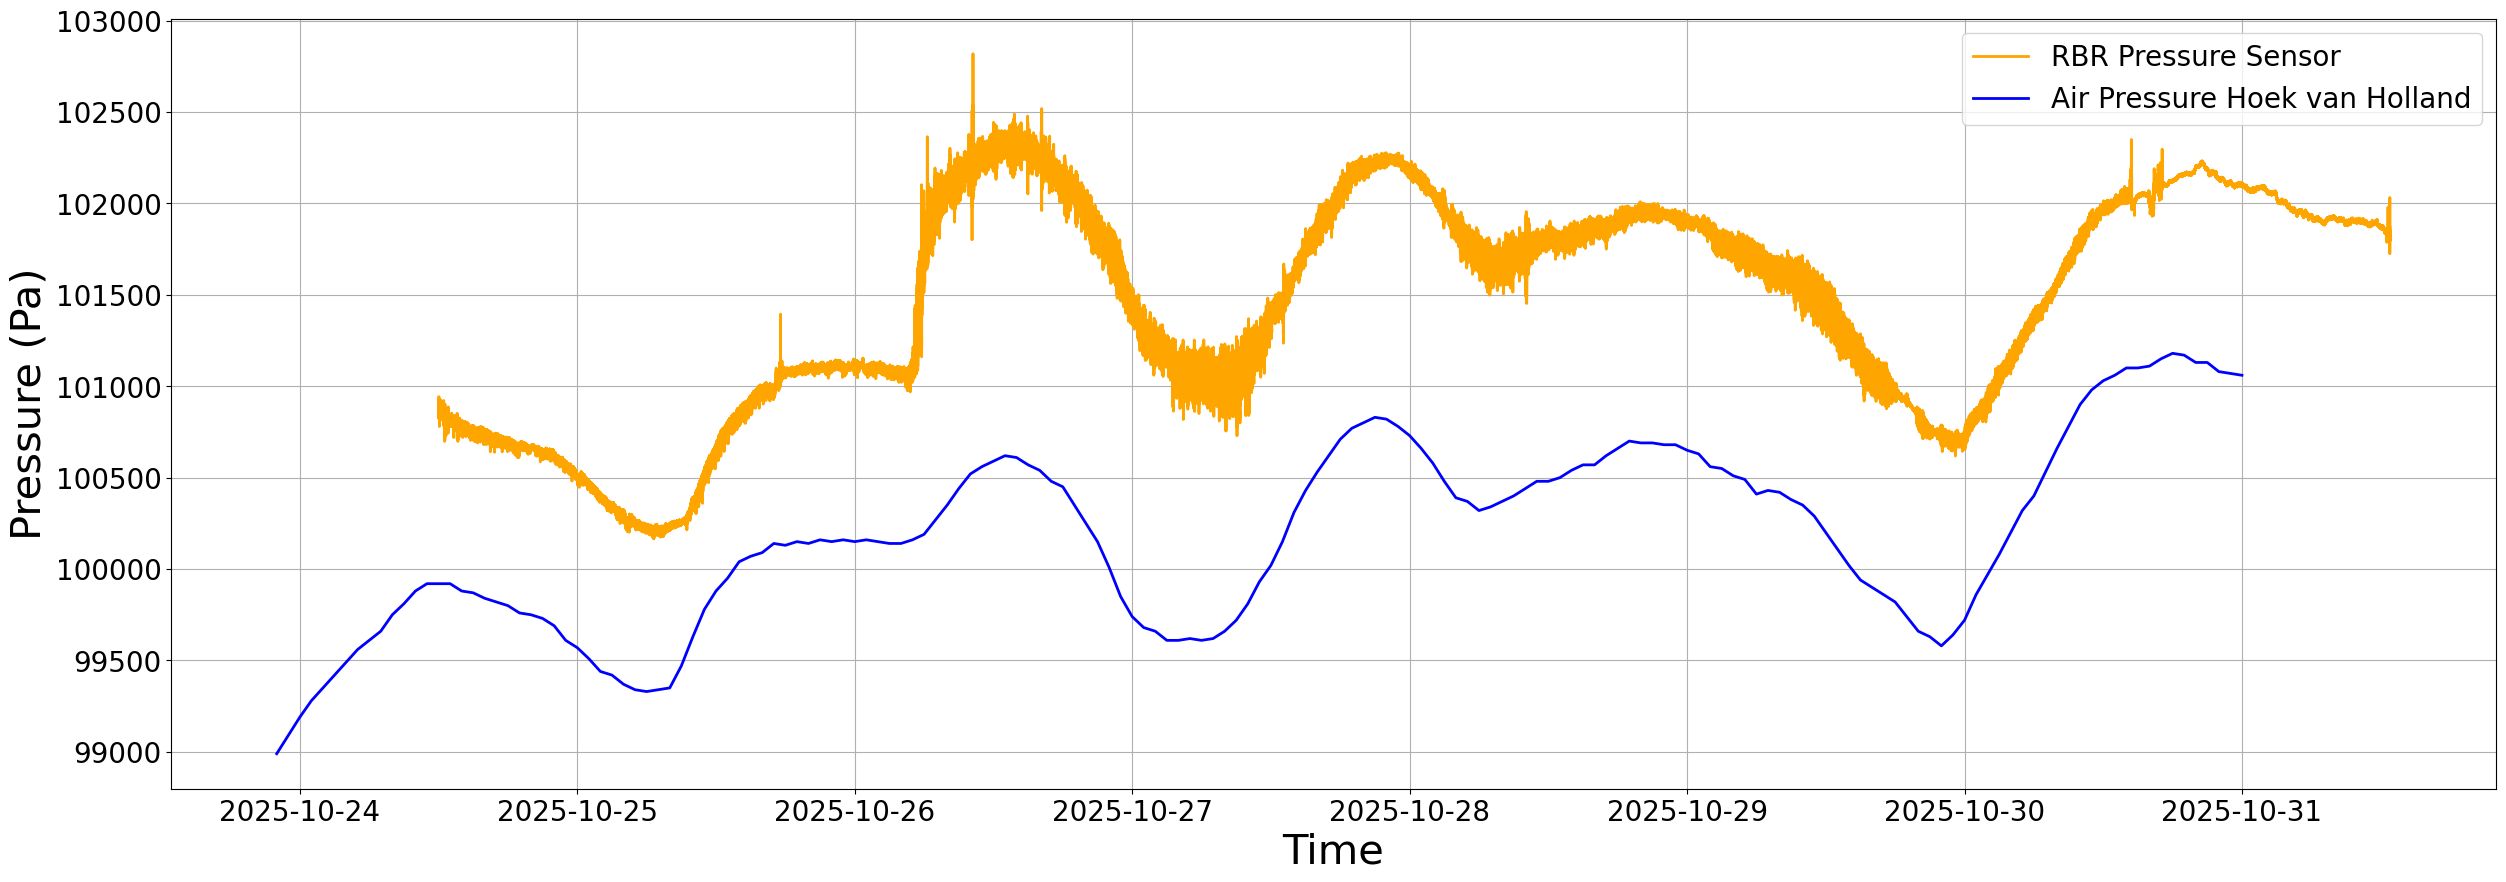

In [12]:
## Plot RBR & Air Pressure Data

# Plot Air Pressure Data

plt.figure(1,figsize=(30,10))
plt.plot(air_pressure.index, air_pressure['P'], color='blue', linewidth=2)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Air Pressure (Pa)', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

## Plot raw RBR data and air pressure data

plt.figure(1,figsize=(30,10))
plt.plot(rbr_data['time'], rbr_data['pressure'], label='RBR Pressure Sensor', color='orange', linewidth=2)
plt.plot(air_pressure.index, air_pressure['P'] , label='Air Pressure Hoek van Holland', color='blue', linewidth=2)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Pressure (Pa)', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()



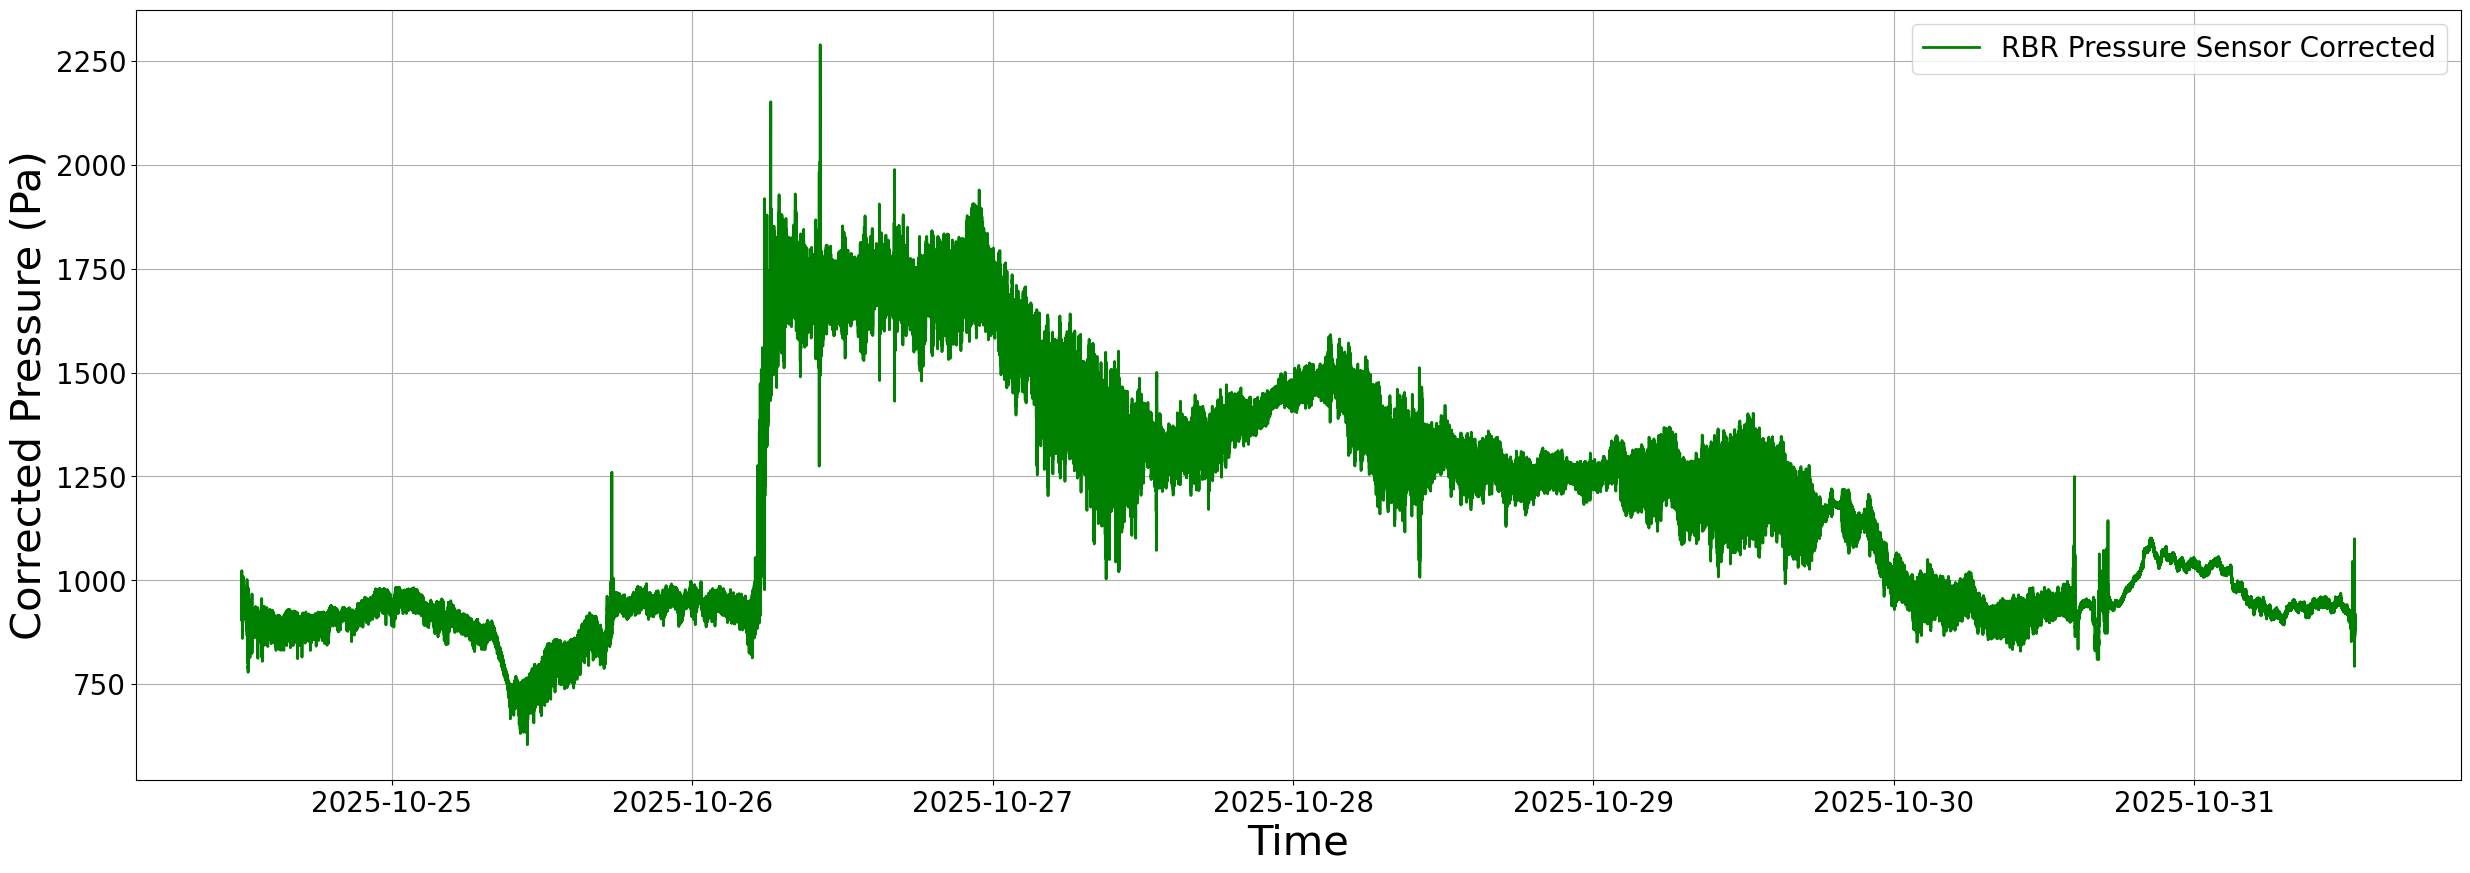

In [13]:
## Correct RBR pressure data for air pressure variations

# Interpolate air pressure data to RBR time vector
f_interp = interp1d(pd.to_numeric(air_pressure_raw['time'])/10**9, air_pressure['P'], kind='linear', fill_value='extrapolate')
air_pressure_interpolated = f_interp(pd.to_numeric(rbr_data['time'])/10**9)

# Correct RBR pressure data for air pressure variations
pressure_corrected = rbr_data['pressure'] - air_pressure_interpolated 

## Plot corrected RBR pressure data
plt.figure(1,figsize=(30,10))
plt.plot(rbr_data['time'], pressure_corrected, label='RBR Pressure Sensor Corrected', color='green', linewidth=2)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Corrected Pressure (Pa)', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim([pd.Timestamp("2025-10-26 05:15:00"), pd.Timestamp("2025-10-26 06:30:00")]) # Set time window
plt.legend(fontsize=20)
plt.grid()
plt.show()

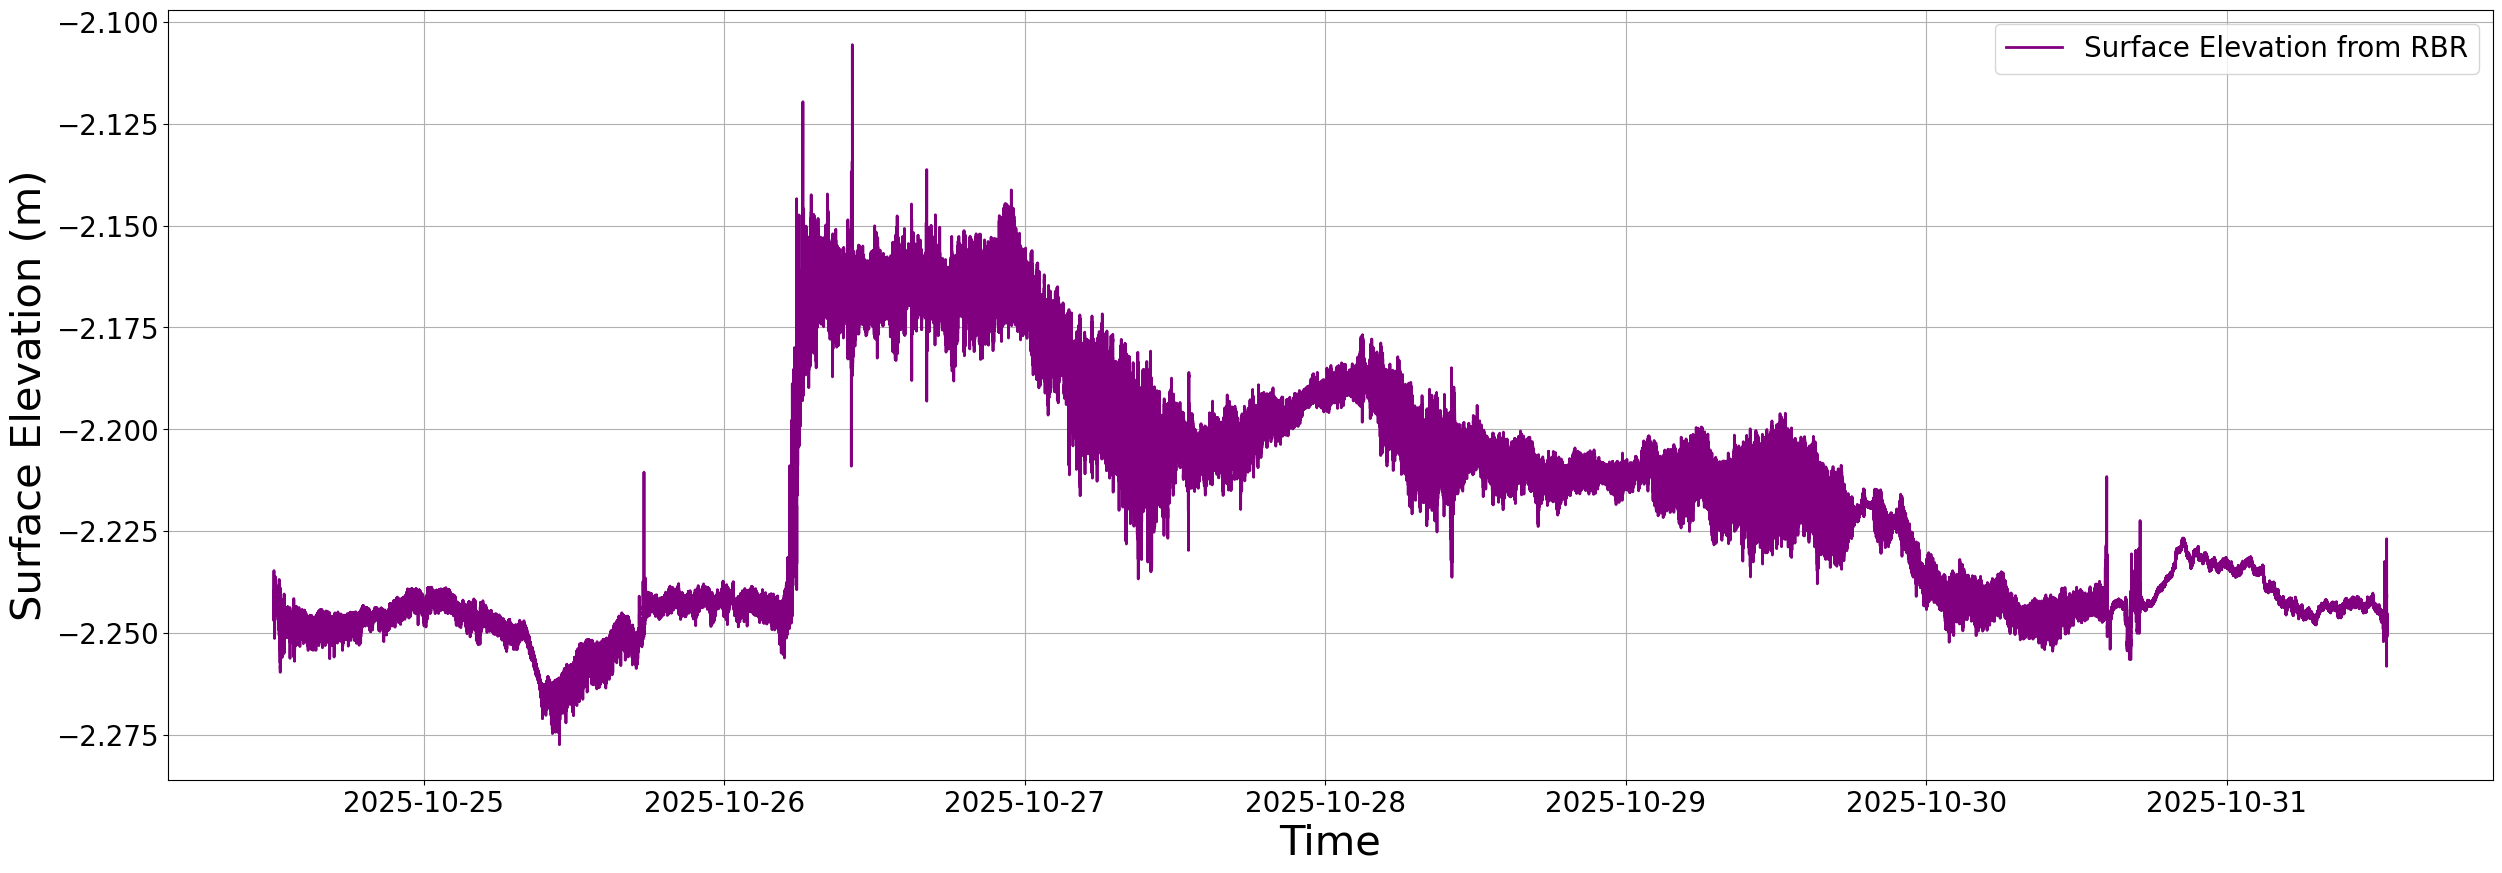

In [14]:
## Convert corrected pressure data to surface elevation

# Define sensor parameters
z_sensor = 2.119  # NAP of the sensor below mean sea level in m
sensor_height = 0.22  # height of the sensor above the bed in m
eta = convert_pressure_to_surface_elevation(pressure_corrected, z_sensor, sensor_height)

## Plot surface elevation time series
plt.figure(1,figsize=(30,10))
plt.plot(rbr_data['time'], eta, label='Surface Elevation from RBR', color='purple', linewidth=2)
plt.xlabel('Time', fontsize=30)
plt.ylabel('Surface Elevation (m)', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()


